In [1]:
# !pip install pyspark==3.5.1
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import when, to_timestamp, col, lit, count, when, avg, sum, hour, unix_timestamp, expr, mean, stddev, count, corr
from pyspark.sql.functions import sum as spark_sum  
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, BooleanType, DoubleType, IntegerType

/Users/suhaibchoudhry/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preprocessing

In [2]:
# Create Spark session with specific configurations
spark = SparkSession.builder.master("local[*]").config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()

24/07/17 18:24:14 WARN Utils: Your hostname, Suhaibs-MacBook-Air.local resolves to a loopback address: 127.0.0.1, but we couldn't find any external IP address!
24/07/17 18:24:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/17 18:24:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv('2021_Green_Taxi_Trip_Data.csv',header=True)

# Save a 'copy' of the original dataframe so it can be used later if needed
original_df = df

In [4]:
df.show(5)

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|       2|01/01/2021 12:15:...| 01/01/2021 12:19:...|                 N|         1|          43|         151|              1|         1.01|        5.5|  0.5|    0.

In [5]:
df.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- lpep_pickup_datetime: string (nullable = true)
 |-- lpep_dropoff_datetime: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- ehail_fee: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- trip_type: string (nullable = true)
 |-- congestion_surcharge: string (nullable = true)



In [6]:
# Currently the schema shows that all columns data types are strings - when they shouldn't all be strings. 
# We can create a new schema with specified data types for each column
schema = StructType([
    StructField('VendorID', IntegerType(), True),
    StructField('lpep_pickup_datetime', StringType(), True), # Reading in as string initially
    StructField('lpep_dropoff_datetime', StringType(), True), # Reading in as string initially
    StructField('store_and_fwd_flag', StringType(), True),
    StructField('RatecodeID', IntegerType(), True),
    StructField('PULocationID', IntegerType(), True),
    StructField('DOLocationID', IntegerType(), True),
    StructField('passenger_count', IntegerType(), True),
    StructField('trip_distance', DoubleType(), True),
    StructField('fare_amount', DoubleType(), True),
    StructField('extra', DoubleType(), True),
    StructField('mta_tax', DoubleType(), True),
    StructField('tip_amount', DoubleType(), True),
    StructField('tolls_amount', DoubleType(), True),
    StructField('ehail_fee', DoubleType(), True),
    StructField('improvement_surcharge', DoubleType(), True),
    StructField('total_amount', DoubleType(), True),
    StructField('payment_type', IntegerType(), True),
    StructField('trip_type', IntegerType(), True),
    StructField('congestion_surcharge', DoubleType(), True)
])

In [7]:
# Read in dataframe again, this time using the new schema
df = spark.read.csv('2021_Green_Taxi_Trip_Data.csv', schema=schema, header=True)

In [8]:
df.show(5)

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|       2|01/01/2021 12:15:...| 01/01/2021 12:19:...|                 N|         1|          43|         151|              1|         1.01|        5.5|  0.5|    0.

In [9]:
# Convert the datetime columns to TimestampType
# Using HH uses 24 hour time format e.g. 0-23 for hours, using hh uses 12 hour format e.g. 1-12 for hours
df = df.withColumn('lpep_pickup_datetime', to_timestamp('lpep_pickup_datetime', 'MM/dd/yyyy hh:mm:ss a'))
df = df.withColumn('lpep_dropoff_datetime', to_timestamp('lpep_dropoff_datetime', 'MM/dd/yyyy hh:mm:ss a'))

In [10]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- RatecodeID: integer (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- trip_type: integer (nullable = true)
 |-- congestion_surcharge: double (nullable = true)



In [11]:
df.show(5)

+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|VendorID|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|RatecodeID|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+--------+--------------------+---------------------+------------------+----------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|       2| 2021-01-01 00:15:56|  2021-01-01 00:19:52|                 N|         1|          43|         151|              1|         1.01|        5.5|  0.5|    0.

# Add link to where this info can be found

In [12]:
# Mapping values for columns using when 
df = df.withColumn('VendorID', 
                   when(col('VendorID') == 1, 'Creative Mobile Technologies, LLC')
                   .when(col('VendorID') == 2, 'VeriFone Inc.')
                   .otherwise('Unknown')) \
       .withColumn('RatecodeID', 
                   when(col('RatecodeID') == 1, 'Standard rate')
                   .when(col('RatecodeID') == 2, 'JFK')
                   .when(col('RatecodeID') == 3, 'Newark')
                   .when(col('RatecodeID') == 4, 'Nassau or Westchester')
                   .when(col('RatecodeID') == 5, 'Negotiated fare')
                   .when(col('RatecodeID') == 6, 'Group ride')
                   .otherwise('Unknown')) \
       .withColumn('payment_type', 
                   when(col('payment_type') == 1, 'Credit card')
                   .when(col('payment_type') == 2, 'Cash')
                   .when(col('payment_type') == 3, 'No charge')
                   .when(col('payment_type') == 4, 'Dispute')
                   .when(col('payment_type') == 5, 'Unknown')
                   .when(col('payment_type') == 6, 'Voided trip')
                   .otherwise('Unknown')) \
       .withColumn('trip_type', 
                   when(col('trip_type') == 1, 'Street-hail')
                   .when(col('trip_type') == 2, 'Dispatch')
                   .otherwise('Unknown'))

df = df.withColumnRenamed('VendorID', 'vendor_name') \
       .withColumnRenamed('RatecodeID', 'rate_code') 

df.show(truncate=False)

+---------------------------------+--------------------+---------------------+------------------+---------------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+-----------+--------------------+
|vendor_name                      |lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|rate_code      |PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type  |congestion_surcharge|
+---------------------------------+--------------------+---------------------+------------------+---------------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+-----------+--------------------+
|VeriFone Inc.                    |2021-01-01 00:15:56 |2021-01-01 

# Schema has to be changed - columns that were integers (representing some text) should become string cols

In [13]:
df.printSchema()

root
 |-- vendor_name: string (nullable = false)
 |-- lpep_pickup_datetime: timestamp (nullable = true)
 |-- lpep_dropoff_datetime: timestamp (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- rate_code: string (nullable = false)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- ehail_fee: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: string (nullable = false)
 |-- trip_type: string (nullable = false)
 |-- congestion_surcharge: double (nullable = true)



In [14]:
# 'PULocationID' and 'DOLocationID' columns are still numbers 
# However we can create a separate dataframe for this data
# This info is available here https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv

taxi_zone_data = [
    (1, "EWR", "Newark Airport", "EWR"),
    (2, "Queens", "Jamaica Bay", "Boro Zone"),
    (3, "Bronx", "Allerton/Pelham Gardens", "Boro Zone"),
    (4, "Manhattan", "Alphabet City", "Yellow Zone"),
    (5, "Staten Island", "Arden Heights", "Boro Zone"),
    (6, "Staten Island", "Arrochar/Fort Wadsworth", "Boro Zone"),
    (7, "Queens", "Astoria", "Boro Zone"),
    (8, "Queens", "Astoria Park", "Boro Zone"),
    (9, "Queens", "Auburndale", "Boro Zone"),
    (10, "Queens", "Baisley Park", "Boro Zone"),
    (11, "Brooklyn", "Bath Beach", "Boro Zone"),
    (12, "Manhattan", "Battery Park", "Yellow Zone"),
    (13, "Manhattan", "Battery Park City", "Yellow Zone"),
    (14, "Brooklyn", "Bay Ridge", "Boro Zone"),
    (15, "Queens", "Bay Terrace/Fort Totten", "Boro Zone"),
    (16, "Queens", "Bayside", "Boro Zone"),
    (17, "Brooklyn", "Bedford", "Boro Zone"),
    (18, "Bronx", "Bedford Park", "Boro Zone"),
    (19, "Queens", "Bellerose", "Boro Zone"),
    (20, "Bronx", "Belmont", "Boro Zone"),
    (21, "Brooklyn", "Bensonhurst East", "Boro Zone"),
    (22, "Brooklyn", "Bensonhurst West", "Boro Zone"),
    (23, "Staten Island", "Bloomfield/Emerson Hill", "Boro Zone"),
    (24, "Manhattan", "Bloomingdale", "Yellow Zone"),
    (25, "Brooklyn", "Boerum Hill", "Boro Zone"),
    (26, "Brooklyn", "Borough Park", "Boro Zone"),
    (27, "Queens", "Breezy Point/Fort Tilden/Riis Beach", "Boro Zone"),
    (28, "Queens", "Briarwood/Jamaica Hills", "Boro Zone"),
    (29, "Brooklyn", "Brighton Beach", "Boro Zone"),
    (30, "Queens", "Broad Channel", "Boro Zone"),
    (31, "Bronx", "Bronx Park", "Boro Zone"),
    (32, "Bronx", "Bronxdale", "Boro Zone"),
    (33, "Brooklyn", "Brooklyn Heights", "Boro Zone"),
    (34, "Brooklyn", "Brooklyn Navy Yard", "Boro Zone"),
    (35, "Brooklyn", "Brownsville", "Boro Zone"),
    (36, "Brooklyn", "Bushwick North", "Boro Zone"),
    (37, "Brooklyn", "Bushwick South", "Boro Zone"),
    (38, "Queens", "Cambria Heights", "Boro Zone"),
    (39, "Brooklyn", "Canarsie", "Boro Zone"),
    (40, "Brooklyn", "Carroll Gardens", "Boro Zone"),
    (41, "Manhattan", "Central Harlem", "Boro Zone"),
    (42, "Manhattan", "Central Harlem North", "Boro Zone"),
    (43, "Manhattan", "Central Park", "Yellow Zone"),
    (44, "Staten Island", "Charleston/Tottenville", "Boro Zone"),
    (45, "Manhattan", "Chinatown", "Yellow Zone"),
    (46, "Bronx", "City Island", "Boro Zone"),
    (47, "Bronx", "Claremont/Bathgate", "Boro Zone"),
    (48, "Manhattan", "Clinton East", "Yellow Zone"),
    (49, "Brooklyn", "Clinton Hill", "Boro Zone"),
    (50, "Manhattan", "Clinton West", "Yellow Zone"),
    (51, "Bronx", "Co-Op City", "Boro Zone"),
    (52, "Brooklyn", "Cobble Hill", "Boro Zone"),
    (53, "Queens", "College Point", "Boro Zone"),
    (54, "Brooklyn", "Columbia Street", "Boro Zone"),
    (55, "Brooklyn", "Coney Island", "Boro Zone"),
    (56, "Queens", "Corona", "Boro Zone"),
    (57, "Queens", "Corona", "Boro Zone"),
    (58, "Bronx", "Country Club", "Boro Zone"),
    (59, "Bronx", "Crotona Park", "Boro Zone"),
    (60, "Bronx", "Crotona Park East", "Boro Zone"),
    (61, "Brooklyn", "Crown Heights North", "Boro Zone"),
    (62, "Brooklyn", "Crown Heights South", "Boro Zone"),
    (63, "Brooklyn", "Cypress Hills", "Boro Zone"),
    (64, "Queens", "Douglaston", "Boro Zone"),
    (65, "Brooklyn", "Downtown Brooklyn/MetroTech", "Boro Zone"),
    (66, "Brooklyn", "DUMBO/Vinegar Hill", "Boro Zone"),
    (67, "Brooklyn", "Dyker Heights", "Boro Zone"),
    (68, "Manhattan", "East Chelsea", "Yellow Zone"),
    (69, "Bronx", "East Concourse/Concourse Village", "Boro Zone"),
    (70, "Queens", "East Elmhurst", "Boro Zone"),
    (71, "Brooklyn", "East Flatbush/Farragut", "Boro Zone"),
    (72, "Brooklyn", "East Flatbush/Remsen Village", "Boro Zone"),
    (73, "Queens", "East Flushing", "Boro Zone"),
    (74, "Manhattan", "East Harlem North", "Boro Zone"),
    (75, "Manhattan", "East Harlem South", "Boro Zone"),
    (76, "Brooklyn", "East New York", "Boro Zone"),
    (77, "Brooklyn", "East New York/Pennsylvania Avenue", "Boro Zone"),
    (78, "Bronx", "East Tremont", "Boro Zone"),
    (79, "Manhattan", "East Village", "Yellow Zone"),
    (80, "Brooklyn", "East Williamsburg", "Boro Zone"),
    (81, "Bronx", "Eastchester", "Boro Zone"),
    (82, "Queens", "Elmhurst", "Boro Zone"),
    (83, "Queens", "Elmhurst/Maspeth", "Boro Zone"),
    (84, "Staten Island", "Eltingville/Annadale/Prince's Bay", "Boro Zone"),
    (85, "Brooklyn", "Erasmus", "Boro Zone"),
    (86, "Queens", "Far Rockaway", "Boro Zone"),
    (87, "Manhattan", "Financial District North", "Yellow Zone"),
    (88, "Manhattan", "Financial District South", "Yellow Zone"),
    (89, "Brooklyn", "Flatbush/Ditmas Park", "Boro Zone"),
    (90, "Manhattan", "Flatiron", "Yellow Zone"),
    (91, "Brooklyn", "Flatlands", "Boro Zone"),
    (92, "Queens", "Flushing", "Boro Zone"),
    (93, "Queens", "Flushing Meadows-Corona Park", "Boro Zone"),
    (94, "Bronx", "Fordham South", "Boro Zone"),
    (95, "Queens", "Forest Hills", "Boro Zone"),
    (96, "Queens", "Forest Park/Highland Park", "Boro Zone"),
    (97, "Brooklyn", "Fort Greene", "Boro Zone"),
    (98, "Queens", "Fresh Meadows", "Boro Zone"),
    (99, "Staten Island", "Freshkills Park", "Boro Zone"),
    (100, "Manhattan", "Garment District", "Yellow Zone"),
    (101, "Queens", "Glen Oaks", "Boro Zone"),
    (102, "Queens", "Glendale", "Boro Zone"),
    (103, "Manhattan", "Governor's Island/Ellis Island/Liberty Island", "Yellow Zone"),
    (104, "Manhattan", "Governor's Island/Ellis Island/Liberty Island", "Yellow Zone"),
    (105, "Manhattan", "Governor's Island/Ellis Island/Liberty Island", "Yellow Zone"),
    (106, "Brooklyn", "Gowanus", "Boro Zone"),
    (107, "Manhattan", "Gramercy", "Yellow Zone"),
    (108, "Brooklyn", "Gravesend", "Boro Zone"),
    (109, "Staten Island", "Great Kills", "Boro Zone"),
    (110, "Staten Island", "Great Kills Park", "Boro Zone"),
    (111, "Brooklyn", "Green-Wood Cemetery", "Boro Zone"),
    (112, "Brooklyn", "Greenpoint", "Boro Zone"),
    (113, "Manhattan", "Greenwich Village North", "Yellow Zone"),
    (114, "Manhattan", "Greenwich Village South", "Yellow Zone"),
    (115, "Staten Island", "Grymes Hill/Clifton", "Boro Zone"),
    (116, "Manhattan", "Hamilton Heights", "Boro Zone"),
    (117, "Brooklyn", "Hammels/Arverne", "Boro Zone"),
    (118, "Staten Island", "Heartland Village/Todt Hill", "Boro Zone"),
    (119, "Bronx", "Highbridge", "Boro Zone"),
    (120, "Queens", "Hillcrest/Pomonok", "Boro Zone"),
    (121, "Queens", "Hollis", "Boro Zone"),
    (122, "Brooklyn", "Homecrest", "Boro Zone"),
    (123, "Queens", "Howard Beach", "Boro Zone"),
    (124, "Bronx", "Hunts Point", "Boro Zone"),
    (125, "Brooklyn", "Jackie Robinson Park", "Boro Zone"),
    (126, "Manhattan", "Javits Center", "Yellow Zone"),
    (127, "Brooklyn", "Kensington", "Boro Zone"),
    (128, "Queens", "Kew Gardens", "Boro Zone"),
    (129, "Queens", "Kew Gardens Hills", "Boro Zone"),
    (130, "Bronx", "Kingsbridge Heights", "Boro Zone"),
    (131, "Manhattan", "Kips Bay", "Yellow Zone"),
    (132, "Brooklyn", "LaGuardia Airport", "Boro Zone"),
    (133, "Queens", "Laurelton", "Boro Zone"),
    (134, "Brooklyn", "Lefferts Gardens", "Boro Zone"),
    (135, "Brooklyn", "Lindenwood", "Boro Zone"),
    (136, "Manhattan", "Little Italy/NoLiTa", "Yellow Zone"),
    (137, "Queens", "Long Island City/Hunters Point", "Boro Zone"),
    (138, "Queens", "Long Island City/Queens Plaza", "Boro Zone"),
    (139, "Bronx", "Longwood", "Boro Zone"),
    (140, "Brooklyn", "Madison", "Boro Zone"),
    (141, "Manhattan", "Manhattan Beach", "Yellow Zone"),
    (142, "Queens", "Manhattanville", "Boro Zone"),
    (143, "Brooklyn", "Manor Heights/Fingerboard Road", "Boro Zone"),
    (144, "Brooklyn", "Marine Park/Floyd Bennett Field", "Boro Zone"),
    (145, "Brooklyn", "Mariners Harbor", "Boro Zone"),
    (146, "Brooklyn", "Maspeth", "Boro Zone"),
    (147, "Manhattan", "Meatpacking/West Village West", "Yellow Zone"),
    (148, "Manhattan", "Melrose South", "Boro Zone"),
    (149, "Brooklyn", "Middle Village", "Boro Zone"),
    (150, "Bronx", "Morrisania/Melrose", "Boro Zone"),
    (151, "Bronx", "Mott Haven/Port Morris", "Boro Zone"),
    (152, "Bronx", "Mount Hope", "Boro Zone"),
    (153, "Manhattan", "Murray Hill", "Yellow Zone"),
    (154, "Manhattan", "Navy Yard", "Yellow Zone"),
    (155, "Queens", "Neponsit", "Boro Zone"),
    (156, "Brooklyn", "New Lots", "Boro Zone"),
    (157, "Staten Island", "New Springville/Bloomfield/Travis", "Boro Zone"),
    (158, "Manhattan", "NoHo", "Yellow Zone"),
    (159, "Brooklyn", "North Riverdale/Fieldston", "Boro Zone"),
    (160, "Manhattan", "Norwood", "Boro Zone"),
    (161, "Queens", "Oakland Gardens", "Boro Zone"),
    (162, "Queens", "Ozone Park", "Boro Zone"),
    (163, "Queens", "Park Slope", "Boro Zone"),
    (164, "Queens", "Parkchester", "Boro Zone"),
    (165, "Manhattan", "Pelham Bay", "Yellow Zone"),
    (166, "Bronx", "Pelham Bay Park", "Boro Zone"),
    (167, "Bronx", "Pelham Parkway", "Boro Zone"),
    (168, "Brooklyn", "Plum Beach", "Boro Zone"),
    (169, "Brooklyn", "Prospect Heights", "Boro Zone"),
    (170, "Brooklyn", "Prospect-Lefferts Gardens", "Boro Zone"),
    (171, "Manhattan", "Randalls Island", "Yellow Zone"),
    (172, "Brooklyn", "Red Hook", "Boro Zone"),
    (173, "Queens", "Rego Park", "Boro Zone"),
    (174, "Queens", "Richmond Hill", "Boro Zone"),
    (175, "Staten Island", "Ridgewood", "Boro Zone"),
    (176, "Queens", "Rikers Island", "Boro Zone"),
    (177, "Manhattan", "Roosevelt Island", "Yellow Zone"),
    (178, "Queens", "Rosedale", "Boro Zone"),
    (179, "Staten Island", "Rossville/Woodrow", "Boro Zone"),
    (180, "Brooklyn", "Saint Albans", "Boro Zone"),
    (181, "Brooklyn", "Saint George/New Brighton", "Boro Zone"),
    (182, "Manhattan", "Saint Michaels Cemetery", "Yellow Zone"),
    (183, "Queens", "Sheepshead Bay", "Boro Zone"),
    (184, "Queens", "South Jamaica", "Boro Zone"),
    (185, "Queens", "South Ozone Park", "Boro Zone"),
    (186, "Queens", "Springfield Gardens North", "Boro Zone"),
    (187, "Queens", "Springfield Gardens South", "Boro Zone"),
    (188, "Bronx", "Spuyten Duyvil/Kingsbridge", "Boro Zone"),
    (189, "Staten Island", "Stapleton", "Boro Zone"),
    (190, "Brooklyn", "Starrett City", "Boro Zone"),
    (191, "Manhattan", "Steinway", "Yellow Zone"),
    (192, "Staten Island", "Stuyvesant Heights", "Boro Zone"),
    (193, "Brooklyn", "Sunnyside", "Boro Zone"),
    (194, "Manhattan", "Sunset Park East", "Yellow Zone"),
    (195, "Queens", "Sunset Park West", "Boro Zone"),
    (196, "Queens", "Sutton Place/Turtle Bay North", "Boro Zone"),
    (197, "Manhattan", "Times Square/Theater District", "Yellow Zone"),
    (198, "Manhattan", "TriBeCa/Civic Center", "Yellow Zone"),
    (199, "Bronx", "University Heights/Morris Heights", "Boro Zone"),
    (200, "Queens", "Upper East Side North", "Boro Zone"),
    (201, "Manhattan", "Upper East Side South", "Yellow Zone"),
    (202, "Bronx", "Upper West Side North", "Boro Zone"),
    (203, "Manhattan", "Upper West Side South", "Yellow Zone"),
    (204, "Manhattan", "Van Cortlandt Park", "Yellow Zone"),
    (205, "Bronx", "Van Cortlandt Village", "Boro Zone"),
    (206, "Queens", "Van Nest/Morris Park", "Boro Zone"),
    (207, "Bronx", "Washington Heights North", "Boro Zone"),
    (208, "Manhattan", "Washington Heights South", "Yellow Zone"),
    (209, "Manhattan", "West Chelsea/Hudson Yards", "Yellow Zone"),
    (210, "Bronx", "West Farms/Bronx River", "Boro Zone"),
    (211, "Brooklyn", "West Brighton", "Boro Zone"),
    (212, "Bronx", "West Concourse", "Boro Zone"),
    (213, "Brooklyn", "West Maspeth", "Boro Zone"),
    (214, "Queens", "West Village", "Yellow Zone"),
    (215, "Queens", "Westchester Village/Unionport", "Boro Zone"),
    (216, "Brooklyn", "Williamsbridge/Olinville", "Boro Zone"),
    (217, "Brooklyn", "Williamsburg (North Side)", "Boro Zone"),
    (218, "Brooklyn", "Williamsburg (South Side)", "Boro Zone"),
    (219, "Brooklyn", "Windsor Terrace", "Boro Zone"),
    (220, "Queens", "Woodhaven", "Boro Zone"),
    (221, "Queens", "Woodside", "Boro Zone"),
    (222, "Brooklyn", "Wyckoff Heights", "Boro Zone"),
    (223, "Manhattan", "Yorkville", "Yellow Zone"),
    (224, "Staten Island", "Woodlawn/Wakefield", "Boro Zone"),
    (225, "Brooklyn", "Stuyvesant Heights", "Boro Zone"),
    (226, "Queens", "Sunnyside", "Boro Zone"),
    (227, "Brooklyn", "Sunset Park East", "Boro Zone"),
    (228, "Brooklyn", "Sunset Park West", "Boro Zone"),
    (229, "Manhattan", "Sutton Place/Turtle Bay North", "Yellow Zone"),
    (230, "Manhattan", "Times Sq/Theatre District", "Yellow Zone"),
    (231, "Manhattan", "TriBeCa/Civic Center", "Yellow Zone"),
    (232, "Manhattan", "Two Bridges/Seward Park", "Yellow Zone"),
    (233, "Manhattan", "UN/Turtle Bay South", "Yellow Zone"),
    (234, "Manhattan", "Union Sq", "Yellow Zone"),
    (235, "Bronx", "University Heights/Morris Heights", "Boro Zone"),
    (236, "Manhattan", "Upper East Side North", "Yellow Zone"),
    (237, "Manhattan", "Upper East Side South", "Yellow Zone"),
    (238, "Manhattan", "Upper West Side North", "Yellow Zone"),
    (239, "Manhattan", "Upper West Side South", "Yellow Zone"),
    (240, "Bronx", "Van Cortlandt Park", "Boro Zone"),
    (241, "Bronx", "Van Cortlandt Village", "Boro Zone"),
    (242, "Bronx", "Van Nest/Morris Park", "Boro Zone"),
    (243, "Manhattan", "Washington Heights North", "Boro Zone"),
    (244, "Manhattan", "Washington Heights South", "Boro Zone"),
    (245, "Staten Island", "West Brighton", "Boro Zone"),
    (246, "Manhattan", "West Chelsea/Hudson Yards", "Yellow Zone"),
    (247, "Bronx", "West Concourse", "Boro Zone"),
    (248, "Bronx", "West Farms/Bronx River", "Boro Zone"),
    (249, "Manhattan", "West Village", "Yellow Zone"),
    (250, "Bronx", "Westchester Village/Unionport", "Boro Zone"),
    (251, "Staten Island", "Westerleigh", "Boro Zone"),
    (252, "Queens", "Whitestone", "Boro Zone"),
    (253, "Queens", "Willets Point", "Boro Zone"),
    (254, "Bronx", "Williamsbridge/Olinville", "Boro Zone"),
    (255, "Brooklyn", "Williamsburg (North Side)", "Boro Zone"),
    (256, "Brooklyn", "Williamsburg (South Side)", "Boro Zone"),
    (257, "Brooklyn", "Windsor Terrace", "Boro Zone"),
    (258, "Queens", "Woodhaven", "Boro Zone"),
    (259, "Bronx", "Woodlawn/Wakefield", "Boro Zone"),
    (260, "Queens", "Woodside", "Boro Zone"),
    (261, "Manhattan", "World Trade Center", "Yellow Zone"),
    (262, "Manhattan", "Yorkville East", "Yellow Zone"),
    (263, "Manhattan", "Yorkville West", "Yellow Zone"),
    (264, "Unknown", "N/A", "N/A"),
    (265, "N/A", "Outside of NYC", "N/A")
]

In [15]:
# Define the schema for the DataFrame
schema = StructType([
    StructField("LocationID", IntegerType(), True),
    StructField("Borough", StringType(), True),
    StructField("Zone", StringType(), True),
    StructField("service_zone", StringType(), True)
])

# Create the DataFrame using the prepared data and schema
taxi_zone_df = spark.createDataFrame(taxi_zone_data, schema)

# Show the resulting DataFrame
taxi_zone_df.show(truncate=False)

+----------+-------------+-----------------------+------------+
|LocationID|Borough      |Zone                   |service_zone|
+----------+-------------+-----------------------+------------+
|1         |EWR          |Newark Airport         |EWR         |
|2         |Queens       |Jamaica Bay            |Boro Zone   |
|3         |Bronx        |Allerton/Pelham Gardens|Boro Zone   |
|4         |Manhattan    |Alphabet City          |Yellow Zone |
|5         |Staten Island|Arden Heights          |Boro Zone   |
|6         |Staten Island|Arrochar/Fort Wadsworth|Boro Zone   |
|7         |Queens       |Astoria                |Boro Zone   |
|8         |Queens       |Astoria Park           |Boro Zone   |
|9         |Queens       |Auburndale             |Boro Zone   |
|10        |Queens       |Baisley Park           |Boro Zone   |
|11        |Brooklyn     |Bath Beach             |Boro Zone   |
|12        |Manhattan    |Battery Park           |Yellow Zone |
|13        |Manhattan    |Battery Park C

In [16]:
# Check for null values in each column
null_counts = df.select([sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
null_counts.show()

+-----------+--------------------+---------------------+------------------+---------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|vendor_name|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|rate_code|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|trip_type|congestion_surcharge|
+-----------+--------------------+---------------------+------------------+---------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+---------+--------------------+
|          0|                  16|                   20|            412434|        0|           0|           0|         412434|            0|          0|    

In [17]:
# Check the number of rows
num_rows = df.count()

# Check the number of columns
num_columns = len(df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 1068755
Number of columns: 20


# Analysis

This section is split into smaller sections:
* General Trip Analysis
* Passenger and Trip Characteristics
* Payment and Financial Analysis
* Location-Based Analysis
* Time-Based Analysis
* Additional Questions 


### General Trip Analysis

##### What is the distribution of trip distances? 

In [19]:
# Calculate summary statistics for trip distances
summary_stats = df.select(F.col('trip_distance')).summary()
summary_stats.show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|          1068755|
|   mean|147.5683906414482|
| stddev|4121.762826283158|
|    min|              0.0|
|    25%|             1.34|
|    50%|             2.65|
|    75%|             5.87|
|    max|        334303.19|
+-------+-----------------+



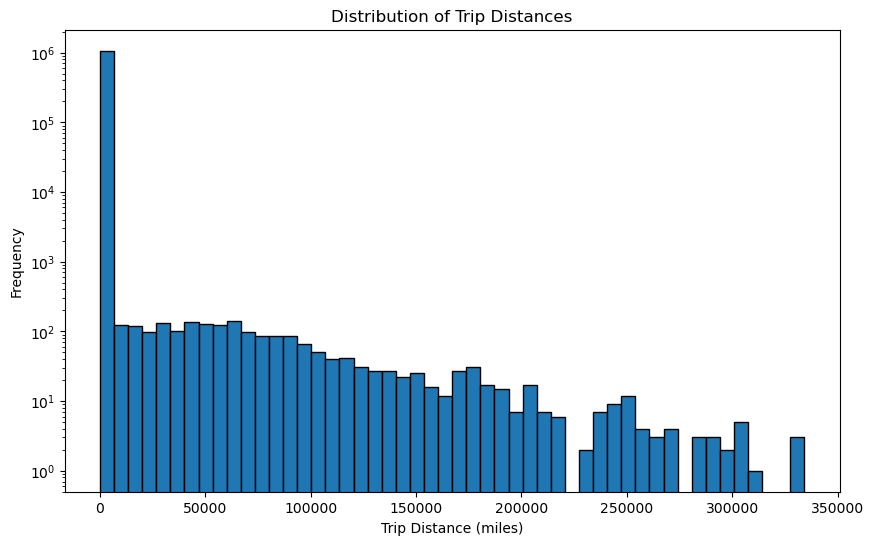

In [20]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
trip_distances = df.select('trip_distance').toPandas()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(trip_distances['trip_distance'], bins=50, edgecolor='black')
plt.title('Distribution of Trip Distances')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Frequency')
plt.yscale('log')  # Use a log scale for the y-axis to handle skewed distributions
plt.show()

##### How does fare amount vary with trip distance? Explore the correlation between fare amount and trip distance.

In [21]:
# Calculate the correlation coefficient between fare_amount and trip_distance
correlation = df.stat.corr('total_amount', 'trip_distance')
print(f"Correlation coefficient between fare amount and trip distance: {correlation}")

Correlation coefficient between fare amount and trip distance: 0.02162639019002754


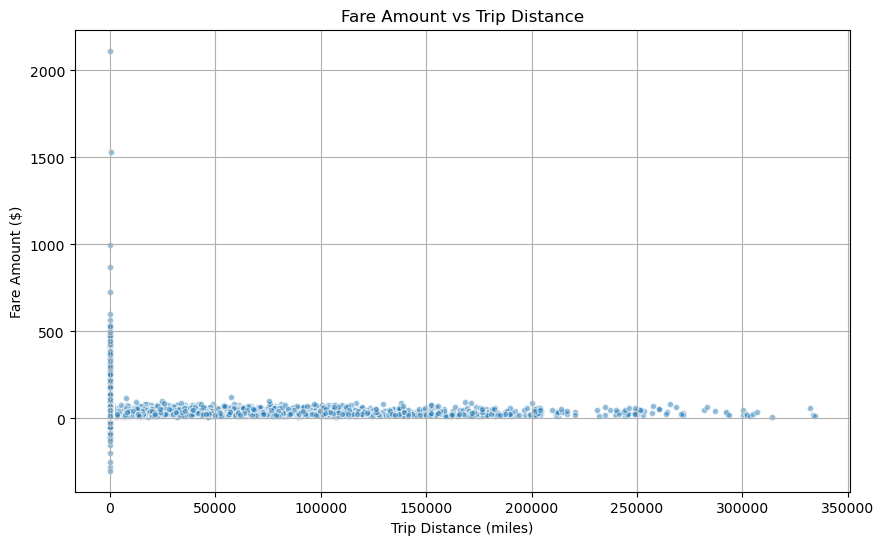

In [22]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
data = df.select('trip_distance', 'total_amount').toPandas()

# Plot scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['trip_distance'], data['total_amount'], alpha=0.5, edgecolors='w', s=20)
plt.title('Fare Amount vs Trip Distance')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.grid(True)
plt.show()


In [23]:
numerical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType))]

In [24]:
# Identify numerical columns
numerical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType))]

# Create an empty dictionary to store correlations
correlation_matrix = {}

# Compute correlations
for col1 in numerical_columns:
    correlations = []
    for col2 in numerical_columns:
        corr = df.stat.corr(col1, col2)
        correlations.append(corr)
    correlation_matrix[col1] = correlations

# Convert to pandas DataFrame for better visualization
correlation_df = pd.DataFrame(correlation_matrix, index=numerical_columns, columns=numerical_columns)

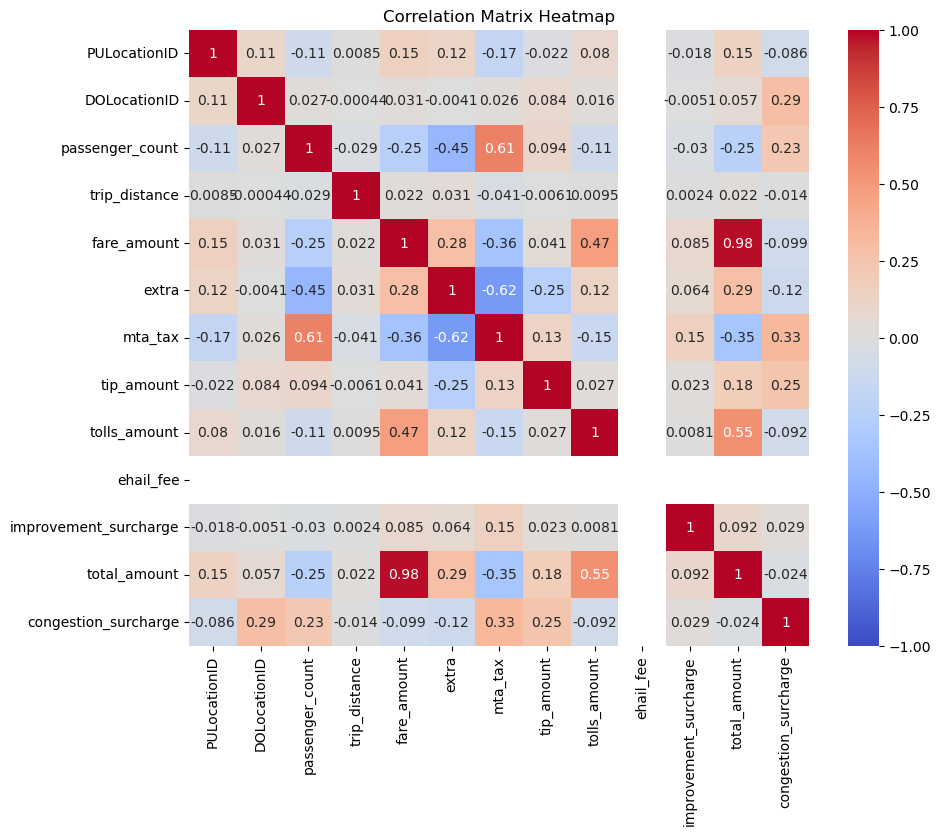

In [25]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

##### What is the average fare amount for each RatecodeID? Compare fare amounts associated with different rate codes.

In [26]:
# Group by RatecodeID and calculate the average fare amount
average_fare_by_ratecode = df.groupBy('rate_code').agg(F.mean('fare_amount').alias('average_fare_amount'))
average_fare_by_ratecode.show()

+--------------------+-------------------+
|           rate_code|average_fare_amount|
+--------------------+-------------------+
|     Negotiated fare| 22.658795476527004|
|Nassau or Westche...|  80.30045871559633|
|             Unknown| 27.595792279771015|
|              Newark| 44.060509554140125|
|       Standard rate|  14.95960207452275|
|                 JFK| 49.053333333333335|
|          Group ride|  4.166666666666667|
+--------------------+-------------------+



##### What time of day sees the highest number of pickups? Identify peak hours for ride requests.

In [27]:
# Extract the hour from the pickup datetime
rc_with_hour = df.withColumn('pickup_hour', F.hour('lpep_pickup_datetime'))

# Group by the extracted hour and count the number of pickups
hourly_pickups = rc_with_hour.groupBy('pickup_hour').count()

# Sort the results by count in descending order
sorted_hourly_pickups = hourly_pickups.orderBy(F.desc('count'))
sorted_hourly_pickups.show(5)

+-----------+-----+
|pickup_hour|count|
+-----------+-----+
|         10|78685|
|         11|76917|
|         12|75701|
|          9|75538|
|         15|74885|
+-----------+-----+
only showing top 5 rows



# How many trips are made per day? - to be calculated

### Passenger and Trip Analysis

##### What is the average number of passengers in a trip?

In [28]:
mean_passengers = df.agg({'passenger_count': 'mean'}).collect()[0][0]

print("Average number of passengers per trip:", mean_passengers)

Average number of passengers per trip: 1.2718745857591027


##### How does the passenger count affect total fare amount?

In [29]:
# Group by passenger_count and calculate the average total_amount
passenger_fare = df.groupBy("passenger_count").avg("total_amount")
passenger_fare.show()

+---------------+------------------+
|passenger_count| avg(total_amount)|
+---------------+------------------+
|           NULL| 31.95709839634867|
|              1|18.730076797073668|
|              6|15.161380682383129|
|              3|19.165348033372823|
|              5|16.636381925100384|
|              4|25.218200136611998|
|              8|12.892727272727278|
|              7|22.571739130434782|
|              2|21.614756071560382|
|              0| 16.38707197763804|
|              9|10.591111111111111|
|             48|              40.3|
|             32|             60.35|
+---------------+------------------+



In [30]:
# Convert to Pandas DataFrame for better visualization
passenger_fare_df = passenger_fare.toPandas()

# Rename columns for better readability
passenger_fare_df.columns = ["passenger_count", "average_total_amount"]

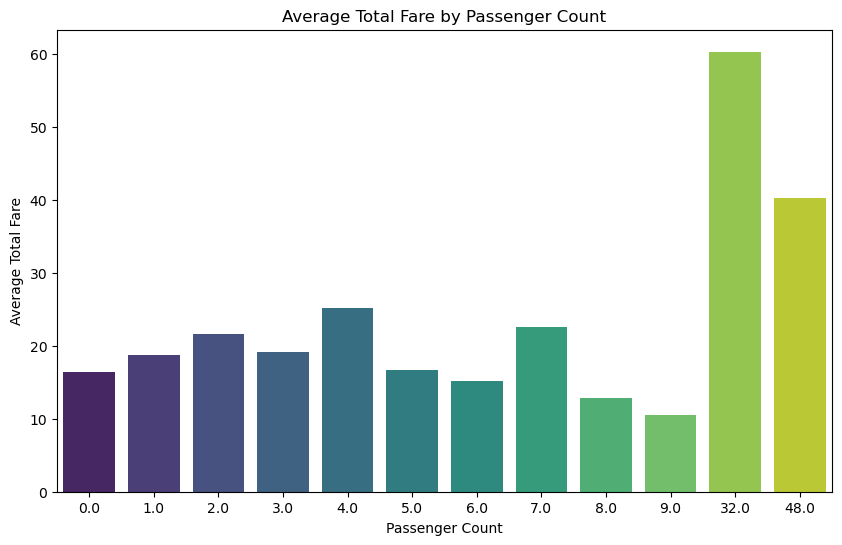

In [31]:
# Plot the relationship between passenger count and average total fare
plt.figure(figsize=(10, 6))
sns.barplot(x="passenger_count", y="average_total_amount", data=passenger_fare_df, palette="viridis")
plt.title('Average Total Fare by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Average Total Fare')
plt.show()

##### What is the distribution of trip types in the dataset? Analyze how different trip types are represented.

+-----------+------+
|  trip_type| count|
+-----------+------+
|Street-hail|631877|
|    Unknown|412434|
|   Dispatch| 24444|
+-----------+------+



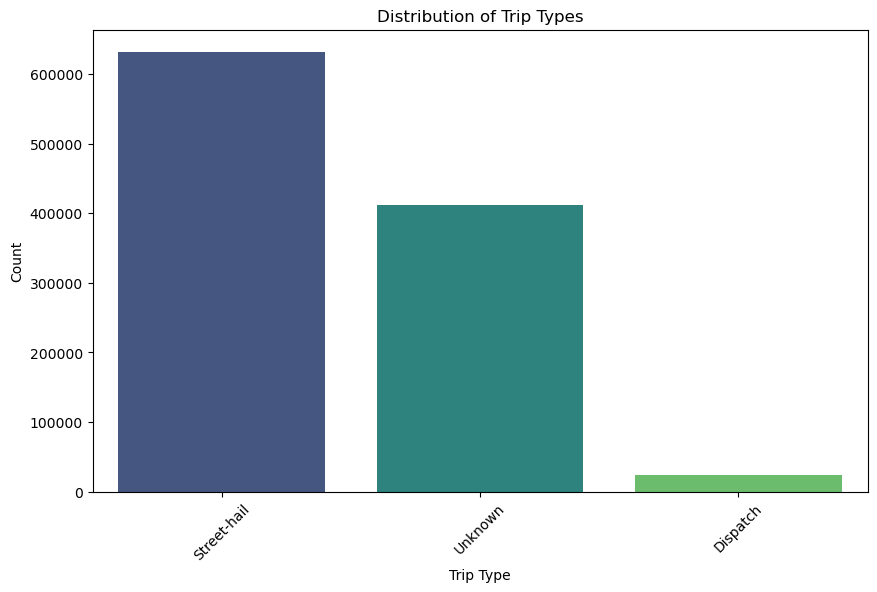

In [32]:
# Count the occurrences of each trip type
trip_type_counts = df.groupBy("trip_type").count()
trip_type_counts.show()

# Convert to Pandas DataFrame for better visualization
trip_type_counts_df = trip_type_counts.toPandas()

# Rename columns for better readability
trip_type_counts_df.columns = ["trip_type", "count"]

# Plot the distribution of trip types
plt.figure(figsize=(10, 6))
sns.barplot(x="trip_type", y="count", data=trip_type_counts_df, palette="viridis")
plt.title('Distribution of Trip Types')
plt.xlabel('Trip Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Payment and Financial Analysis

##### What is the average tip amount per trip? Explore average tips and their distribution.

In [33]:
# Calculate the average tip amount per trip
average_tip = df.agg(avg("tip_amount")).collect()[0][0]
print(f"Average Tip Amount per Trip: {average_tip}")

Average Tip Amount per Trip: 1.1474485452699814


##### How do different payment types impact fare amounts? Compare average fares based on payment type.

In [34]:
# Calculate average fare amount by payment type
average_fares = df.groupBy("payment_type").agg(avg("fare_amount").alias("average_fare")).orderBy("payment_type")
average_fares.show()

+------------+------------------+
|payment_type|      average_fare|
+------------+------------------+
|        Cash|12.492542946843898|
| Credit card|17.569913124876734|
|     Dispute|3.8020164986251146|
|   No charge| 1.913186022610483|
|     Unknown| 27.59445515843302|
+------------+------------------+



In [35]:
# Convert to Pandas DataFrame for visualization
average_fares_pd = average_fares.toPandas()

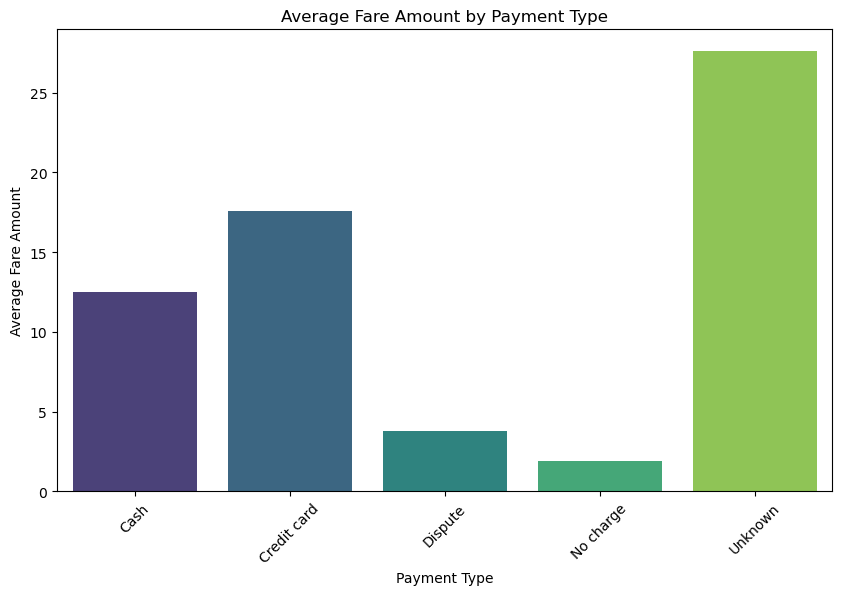

In [36]:
# Plot the average fare amounts by payment type
plt.figure(figsize=(10, 6))
sns.barplot(data=average_fares_pd, x='payment_type', y='average_fare', palette='viridis')
plt.title('Average Fare Amount by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Average Fare Amount')
plt.xticks(rotation=45)
plt.show()

##### What percentage of total fare is made up of tips? Analyze the contribution of tips to total fare amounts.

In [37]:
# Calculate total fare and total tip amounts
totals = df.agg(
    spark_sum("total_amount").alias("total_fare"),  
    spark_sum("tip_amount").alias("total_tips")      
).collect()[0]

total_fare = totals["total_fare"]
total_tips = totals["total_tips"]

# Calculate the percentage of total fare that is made up of tips
tip_percentage = (total_tips / total_fare) * 100 if total_fare != 0 else 0

print(f"Total Fare: ${total_fare:.2f}")
print(f"Total Tips: ${total_tips:.2f}")
print(f"Percentage of Total Fare Made Up of Tips: {tip_percentage:.2f}%")


Total Fare: $25578020.24
Total Tips: $1226341.37
Percentage of Total Fare Made Up of Tips: 4.79%


### Location Based Analysis

##### Which pickup and drop-off locations are the most popular? Identify the most common pickup and drop-off locations.

In [38]:
taxi_zone_df.show(5)

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
+----------+-------------+--------------------+------------+
only showing top 5 rows



In [39]:
# Count the occurrences of each pickup location
popular_pickups = df.groupBy("PULocationID").count().orderBy(F.col("count").desc()).limit(10)

# Rename the LocationID in the taxi_zone_df
temp_taxi_zone_df = taxi_zone_df.withColumnRenamed("LocationID", "PULocationID")

# Join with taxi zone data
popular_pickups = popular_pickups.join(temp_taxi_zone_df, on=['PULocationID'], how='left')

# Reorder based on count after joining
popular_pickups = popular_pickups.orderBy(F.col("count").desc())

# Repeat the process with dropoffs
popular_dropoffs = df.groupBy("DOLocationID").count().orderBy(F.col("count").desc()).limit(10)
temp_taxi_zone_df = taxi_zone_df.withColumnRenamed("LocationID", "DOLocationID")
popular_dropoffs = popular_dropoffs.join(temp_taxi_zone_df, on=['DOLocationID'], how='left')
popular_dropoffs = popular_dropoffs.orderBy(F.col("count").desc())

print("Most Popular Pickup Locations:")
popular_pickups.show()

print("Most Popular Drop-off Locations:")
popular_dropoffs.show()

Most Popular Pickup Locations:


+------------+------+---------+--------------------+------------+
|PULocationID| count|  Borough|                Zone|service_zone|
+------------+------+---------+--------------------+------------+
|          74|107325|Manhattan|   East Harlem North|   Boro Zone|
|          75| 94201|Manhattan|   East Harlem South|   Boro Zone|
|          41| 58946|Manhattan|      Central Harlem|   Boro Zone|
|          42| 39869|Manhattan|Central Harlem North|   Boro Zone|
|         166| 34268|    Bronx|     Pelham Bay Park|   Boro Zone|
|          95| 32897|   Queens|        Forest Hills|   Boro Zone|
|         244| 31473|Manhattan|Washington Height...|   Boro Zone|
|          97| 22709| Brooklyn|         Fort Greene|   Boro Zone|
|           7| 22109|   Queens|             Astoria|   Boro Zone|
|          82| 20859|   Queens|            Elmhurst|   Boro Zone|
+------------+------+---------+--------------------+------------+

Most Popular Drop-off Locations:


+------------+-----+---------+--------------------+------------+
|DOLocationID|count|  Borough|                Zone|service_zone|
+------------+-----+---------+--------------------+------------+
|          74|43871|Manhattan|   East Harlem North|   Boro Zone|
|          75|38776|Manhattan|   East Harlem South|   Boro Zone|
|          42|36090|Manhattan|Central Harlem North|   Boro Zone|
|          41|31929|Manhattan|      Central Harlem|   Boro Zone|
|         236|22184|Manhattan|Upper East Side N...| Yellow Zone|
|         238|20526|Manhattan|Upper West Side N...| Yellow Zone|
|         166|20336|    Bronx|     Pelham Bay Park|   Boro Zone|
|         244|15855|Manhattan|Washington Height...|   Boro Zone|
|          61|15502| Brooklyn| Crown Heights North|   Boro Zone|
|         263|15429|Manhattan|      Yorkville West| Yellow Zone|
+------------+-----+---------+--------------------+------------+



##### How do trip distances vary by pickup location? Explore the average trip distance for different pickup locations.

In [40]:
# Calculate the average trip distance for each pickup location
avg_trip_distance_by_pickup = df.groupBy("PULocationID") \
    .agg(avg("trip_distance").alias("avg_trip_distance")) \
    .orderBy(col("avg_trip_distance").desc())

avg_trip_distance_by_pickup.show()

+------------+------------------+
|PULocationID| avg_trip_distance|
+------------+------------------+
|          13|3180.3683870967748|
|          84|3155.8105555555558|
|         114|1338.3660000000002|
|         100|1225.5945588235295|
|         246|1099.4800729927008|
|         101|1074.4059504132233|
|          27|1051.0565789473687|
|          45|1042.3215835777128|
|         163|1017.5819900497513|
|          19|1012.5166007416566|
|          15| 879.3846242774567|
|         108| 815.8665543478261|
|          64| 762.3359148936172|
|         141| 740.5116091954025|
|         258| 616.7402613827995|
|         126| 602.5135779816515|
|          57| 599.7680412371133|
|          48| 593.6611018711019|
|          78|  570.782983974359|
|           9| 553.6441881443299|
+------------+------------------+
only showing top 20 rows



##### Are there any patterns in trip distances based on time of day? Analyze if trip distances differ significantly during different times of the day.

In [41]:
# Extract the hour from the pickup datetime and create a new column
df = df.withColumn("pickup_hour", hour(col("lpep_pickup_datetime")))

# Calculate the average trip distance for each hour of the day
avg_trip_distance_by_hour = df.groupBy("pickup_hour") \
    .agg(avg("trip_distance").alias("avg_trip_distance")) \
    .orderBy("pickup_hour")

avg_trip_distance_by_hour.show()

+-----------+------------------+
|pickup_hour| avg_trip_distance|
+-----------+------------------+
|       NULL|          5.995625|
|          0|116.14045545826976|
|          1| 69.62686070157592|
|          2|115.94332115384618|
|          3|154.47462658959535|
|          4| 543.8095736658936|
|          5|479.51376922423356|
|          6| 297.1605071601497|
|          7|232.31917059004712|
|          8|201.55164837539576|
|          9|186.64379398448455|
|         10|186.21493207091547|
|         11|155.23666536656373|
|         12|129.39137118400043|
|         13| 131.9680765485939|
|         14|134.62603368533627|
|         15|121.11994792014409|
|         16|132.39018135042815|
|         17|101.85461570674364|
|         18| 81.83555765564398|
+-----------+------------------+
only showing top 20 rows



# 13. Are there notable differences in fare amounts based on pickup locations? Explore fare variations based on where trips start.

### Time-Based Analysis

##### What are the average trip durations? Calculate and analyze the duration of trips based on pickup and drop-off times.

In [42]:
# Calculate trip duration in seconds
df = df.withColumn("trip_duration", 
                   unix_timestamp(col("lpep_dropoff_datetime")) - unix_timestamp(col("lpep_pickup_datetime")))

# Calculate average trip duration
average_trip_duration = df.agg(avg("trip_duration").alias("average_trip_duration")).collect()[0][0]

# Convert seconds to a more readable format (hours:minutes:seconds)
avg_hours = average_trip_duration // 3600
avg_minutes = (average_trip_duration % 3600) // 60
avg_seconds = average_trip_duration % 60

print(f"Average Trip Duration: {avg_hours} hours, {avg_minutes} minutes, and {avg_seconds} seconds.")

Average Trip Duration: 0.0 hours, 24.0 minutes, and 13.433040275765961 seconds.


# - [ ] Are there trends in total earnings over time? Investigate changes in total amounts earned over specific periods.

### Anomaly detection

##### Are there any outliers in fare amounts? Identify and analyze extreme fare amounts to understand their causes.

In [43]:
# Calculate the first and third quartiles (Q1 and Q3) and IQR
quartiles = df.approxQuantile("fare_amount", [0.25, 0.75], 0.01)
Q1 = quartiles[0]
Q3 = quartiles[1]
IQR = Q3 - Q1

# Define upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to find outliers
outliers = df.filter((col("fare_amount") < lower_bound) | (col("fare_amount") > upper_bound))

# Count the number of outliers and show them
outlier_count = outliers.count()
print(f"Number of outliers in fare amounts: {outlier_count}")
outliers.show()

# Optionally, analyze the distribution of outliers
outlier_summary = outliers.agg(
    mean("fare_amount").alias("mean_fare"),
    stddev("fare_amount").alias("stddev_fare"),
    count("*").alias("total_count")
)
outlier_summary.show()

Number of outliers in fare amounts: 53175
+-------------+--------------------+---------------------+------------------+---------------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+-----------+--------------------+-----------+-------------+
|  vendor_name|lpep_pickup_datetime|lpep_dropoff_datetime|store_and_fwd_flag|      rate_code|PULocationID|DOLocationID|passenger_count|trip_distance|fare_amount|extra|mta_tax|tip_amount|tolls_amount|ehail_fee|improvement_surcharge|total_amount|payment_type|  trip_type|congestion_surcharge|pickup_hour|trip_duration|
+-------------+--------------------+---------------------+------------------+---------------+------------+------------+---------------+-------------+-----------+-----+-------+----------+------------+---------+---------------------+------------+------------+-----------+--------------------+-----------+-------------+
|VeriFo

+----------------+-----------------+-----------+
|       mean_fare|      stddev_fare|total_count|
+----------------+-----------------+-----------+
|65.4562920545375|24.10659451300904|      53175|
+----------------+-----------------+-----------+



# - [ ] How does the store_and_fwd_flag affect trip characteristics? Compare trips with and without the flag to identify differences.

### Additional Questions

##### What are the most common combinations of pickup and drop-off locations. Analyze popular route combinations.

In [44]:
# Group by pickup and drop-off locations and count the occurrences
common_routes = df.groupBy("PULocationID", "DOLocationID").count().orderBy(col("count").desc()).limit(10)
common_routes.show()

+------------+------------+-----+
|PULocationID|DOLocationID|count|
+------------+------------+-----+
|          75|          74|15865|
|          74|          75|15392|
|          74|          74| 8727|
|          75|          75| 8217|
|          41|          42| 7690|
|          74|          41| 7635|
|          74|         236| 7517|
|          95|          95| 7380|
|          74|          42| 6863|
|          41|          41| 6580|
+------------+------------+-----+



##### Is there a relationship between congestion surcharge and trip distance or time? Investigate how congestion affects fares.

In [45]:
# Calculate the correlation between congestion surcharge and trip distance
congestion_distance_corr = df.stat.corr("congestion_surcharge", "trip_distance")
print(f"Correlation between congestion surcharge and trip distance: {congestion_distance_corr}")

# Calculate the trip duration in minutes
df = df.withColumn("trip_duration", (col("lpep_dropoff_datetime").cast("long") - col("lpep_pickup_datetime").cast("long")) / 60)

# Calculate the correlation between congestion surcharge and trip duration
congestion_duration_corr = df.stat.corr("congestion_surcharge", "trip_duration")
print(f"Correlation between congestion surcharge and trip duration: {congestion_duration_corr}")

Correlation between congestion surcharge and trip distance: -0.014159380273191923


Correlation between congestion surcharge and trip duration: 0.004384937406450324


##### How does the extra charge impact the total amount collected per trip? Explore the effect of additional fees on overall fare.


In [46]:
# Calculate the average total amount with and without extra charges
avg_total_with_extra = df.filter(col("extra") > 0).agg(avg("total_amount")).collect()[0][0]
avg_total_without_extra = df.filter(col("extra") == 0).agg(avg("total_amount")).collect()[0][0]

print(f"Average total amount with extra charges: {avg_total_with_extra}")
print(f"Average total amount without extra charges: {avg_total_without_extra}")

# Show the impact of extra charges
impact = avg_total_with_extra - avg_total_without_extra
print(f"Impact of extra charge on total amount collected per trip: {impact}")

Average total amount with extra charges: 26.624058333918335
Average total amount without extra charges: 20.84671965679063
Impact of extra charge on total amount collected per trip: 5.777338677127705


##### What is the most and least popular pickup/drop off locations?

In [47]:
# # Group by RatecodeID and count occurrences
# ratecode_counts = rc.groupBy("PULocationID").agg(count("*").alias("count")).orderBy(col("count").desc())

# # Show the most occurring value
# most_occurring = ratecode_counts.first()
# print(f"Most occurring PULocationID: {most_occurring['PULocationID']} with {most_occurring['count']} occurrences")

# # Show the least occurring value
# least_occurring = ratecode_counts.orderBy(col("count").asc()).first()
# print(f"Least occurring PULocationID: {least_occurring['PULocationID']} with {least_occurring['count']} occurrences")

In [48]:
# # Group by RatecodeID and count occurrences
# ratecode_counts = rc.groupBy("DOLocationID").agg(count("*").alias("count")).orderBy(col("count").desc())

# # Show the most occurring value
# most_occurring = ratecode_counts.first()
# print(f"Most occurring DOLocationID: {most_occurring['DOLocationID']} with {most_occurring['count']} occurrences")

# # Show the least occurring value
# least_occurring = ratecode_counts.orderBy(col("count").asc()).first()
# print(f"Least occurring DOLocationID: {least_occurring['DOLocationID']} with {least_occurring['count']} occurrences")

##### What is the average number of passengers in a trip?

In [49]:
# mean_passengers = df.agg({'passenger_count': 'mean'}).collect()[0][0]

# print("Average number of passengers per trip:", mean_passengers)

In [50]:
# # Calculate the mean of a specific column
# mean_passengers = rc.agg({'passenger_count': 'mode'}).collect()[0][0]

# print("Mode of the column:", mean_passengers)

##### What is the average trip distance?

In [51]:
# # Calculate the mean of a specific column
# mean_passengers = rc.agg({'trip_distance': 'mean'}).collect()[0][0]

# print("Mean of the column:", mean_passengers)

# # Calculate the min and max values of the trip_distance column
# min_max = rc.agg(
#     F.min('trip_distance').alias('min_distance'),
#     F.max('trip_distance').alias('max_distance')
# ).collect()[0]

# # Print the min and max values
# print("Minimum trip_distance:", min_max['min_distance'])
# print("Maximum trip_distance:", min_max['max_distance'])

# # Calculate the range
# range_distance = min_max['max_distance'] - min_max['min_distance']

# print("Range of trip_distance:", range_distance)

In [52]:
# df.show(5)

##### What time of day sees the highest number of pickups? Identify peak hours for ride requests.

In [53]:
# Extract the hour from the pickup datetime
rc_with_hour = df.withColumn('pickup_hour', F.hour('lpep_pickup_datetime'))

# Group by the extracted hour and count the number of pickups
hourly_pickups = rc_with_hour.groupBy('pickup_hour').count()

# Sort the results by count in descending order
sorted_hourly_pickups = hourly_pickups.orderBy(F.desc('count'))
sorted_hourly_pickups.show(5)

+-----------+-----+
|pickup_hour|count|
+-----------+-----+
|         10|78685|
|         11|76917|
|         12|75701|
|          9|75538|
|         15|74885|
+-----------+-----+
only showing top 5 rows



### What is the average fare amount for each RatecodeID? Compare fare amounts associated with different rate codes.

In [54]:
# # Group by RatecodeID and calculate the average fare amount
# average_fare_by_ratecode = df.groupBy('rate_code').agg(F.mean('fare_amount').alias('average_fare_amount'))
# average_fare_by_ratecode.show()

### What is the distribution of trip distances? Analyze how trip distances vary across different trips.

In [55]:
# # Calculate summary statistics for trip distances
# summary_stats = df.select(F.col('trip_distance')).summary()
# summary_stats.show()

In [56]:
# # Convert Spark DataFrame to Pandas DataFrame for visualization
# trip_distances = df.select('trip_distance').toPandas()

# # Plot histogram
# plt.figure(figsize=(10, 6))
# plt.hist(trip_distances['trip_distance'], bins=50, edgecolor='black')
# plt.title('Distribution of Trip Distances')
# plt.xlabel('Trip Distance (miles)')
# plt.ylabel('Frequency')
# plt.yscale('log')  # Use a log scale for the y-axis to handle skewed distributions
# plt.show()

### How does fare amount vary with trip distance? Explore the correlation between fare amount and trip distance.

In [57]:
# # Calculate the correlation coefficient between fare_amount and trip_distance
# correlation = df.stat.corr('total_amount', 'trip_distance')
# print(f"Correlation coefficient between fare amount and trip distance: {correlation}")

In [58]:
# # Convert Spark DataFrame to Pandas DataFrame for visualization
# data = df.select('trip_distance', 'total_amount').toPandas()

# # Plot scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(data['trip_distance'], data['total_amount'], alpha=0.5, edgecolors='w', s=20)
# plt.title('Fare Amount vs Trip Distance')
# plt.xlabel('Trip Distance (miles)')
# plt.ylabel('Fare Amount ($)')
# plt.grid(True)
# plt.show()


In [59]:
# numerical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType))]

In [60]:
# # Identify numerical columns
# numerical_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, (IntegerType, DoubleType))]

# # Create an empty dictionary to store correlations
# correlation_matrix = {}

# # Compute correlations
# for col1 in numerical_columns:
#     correlations = []
#     for col2 in numerical_columns:
#         corr = df.stat.corr(col1, col2)
#         correlations.append(corr)
#     correlation_matrix[col1] = correlations

# # Convert to pandas DataFrame for better visualization
# correlation_df = pd.DataFrame(correlation_matrix, index=numerical_columns, columns=numerical_columns)

In [61]:
# # Plot the heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Matrix Heatmap')
# plt.show()

### How do passenger counts influence the total fare amount? Investigate the relationship between passenger count and total fare. 

In [62]:
# # Group by passenger_count and calculate the average total_amount
# passenger_fare = df.groupBy("passenger_count").avg("total_amount")

# # Show the result
# passenger_fare.show()

In [63]:
# # Convert to Pandas DataFrame for better visualization
# passenger_fare_df = passenger_fare.toPandas()

# # Rename columns for better readability
# passenger_fare_df.columns = ["passenger_count", "average_total_amount"]

In [64]:
# # Plot the relationship between passenger count and average total fare
# plt.figure(figsize=(10, 6))
# sns.barplot(x="passenger_count", y="average_total_amount", data=passenger_fare_df, palette="viridis")
# plt.title('Average Total Fare by Passenger Count')
# plt.xlabel('Passenger Count')
# plt.ylabel('Average Total Fare')
# plt.show()

### What is the distribution of trip types in the dataset? Analyze how different trip types are represented.

In [65]:
# # Count the occurrences of each trip type
# trip_type_counts = df.groupBy("trip_type").count()
# trip_type_counts.show()

# # Convert to Pandas DataFrame for better visualization
# trip_type_counts_df = trip_type_counts.toPandas()

# # Rename columns for better readability
# trip_type_counts_df.columns = ["trip_type", "count"]

# # Plot the distribution of trip types
# plt.figure(figsize=(10, 6))
# sns.barplot(x="trip_type", y="count", data=trip_type_counts_df, palette="viridis")
# plt.title('Distribution of Trip Types')
# plt.xlabel('Trip Type')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.show()


### What is the average tip amount per trip? Explore average tips and their distribution.

In [66]:
# # Calculate the average tip amount per trip
# average_tip = df.agg(avg("tip_amount")).collect()[0][0]
# print(f"Average Tip Amount per Trip: {average_tip}")

### How do different payment types impact fare amounts? Compare average fares based on payment type.

In [67]:
# # Calculate average fare amount by payment type
# average_fares = df.groupBy("payment_type").agg(avg("fare_amount").alias("average_fare")).orderBy("payment_type")
# average_fares.show()

In [68]:
# # Convert to Pandas DataFrame for visualization
# average_fares_pd = average_fares.toPandas()

In [69]:
# # Plot the average fare amounts by payment type
# plt.figure(figsize=(10, 6))
# sns.barplot(data=average_fares_pd, x='payment_type', y='average_fare', palette='viridis')
# plt.title('Average Fare Amount by Payment Type')
# plt.xlabel('Payment Type')
# plt.ylabel('Average Fare Amount')
# plt.xticks(rotation=45)
# plt.show()

### What percentage of total fare is made up of tips? Analyze the contribution of tips to total fare amounts.

In [70]:
# # Calculate total fare and total tip amounts
# totals = df.agg(
#     spark_sum("total_amount").alias("total_fare"),  
#     spark_sum("tip_amount").alias("total_tips")      
# ).collect()[0]

# total_fare = totals["total_fare"]
# total_tips = totals["total_tips"]

# # Calculate the percentage of total fare that is made up of tips
# tip_percentage = (total_tips / total_fare) * 100 if total_fare != 0 else 0

# print(f"Total Fare: ${total_fare:.2f}")
# print(f"Total Tips: ${total_tips:.2f}")
# print(f"Percentage of Total Fare Made Up of Tips: {tip_percentage:.2f}%")


### Which pickup and drop-off locations are the most popular? Identify the most common pickup and drop-off locations.

In [71]:
# taxi_zone_df.show(5)

In [72]:
# # Count the occurrences of each pickup location
# popular_pickups = df.groupBy("PULocationID").count().orderBy(F.col("count").desc()).limit(10)

# # Rename the LocationID in the taxi_zone_df
# temp_taxi_zone_df = taxi_zone_df.withColumnRenamed("LocationID", "PULocationID")

# # Join with taxi zone data
# popular_pickups = popular_pickups.join(temp_taxi_zone_df, on=['PULocationID'], how='left')

# # Reorder based on count after joining
# popular_pickups = popular_pickups.orderBy(F.col("count").desc())

# # Repeat the process with dropoffs
# popular_dropoffs = df.groupBy("DOLocationID").count().orderBy(F.col("count").desc()).limit(10)
# temp_taxi_zone_df = taxi_zone_df.withColumnRenamed("LocationID", "DOLocationID")
# popular_dropoffs = popular_dropoffs.join(temp_taxi_zone_df, on=['DOLocationID'], how='left')
# popular_dropoffs = popular_dropoffs.orderBy(F.col("count").desc())

# print("Most Popular Pickup Locations:")
# popular_pickups.show()

# print("Most Popular Drop-off Locations:")
# popular_dropoffs.show()

### How do trip distances vary by pickup location? Explore the average trip distance for different pickup locations.

In [73]:
# # Calculate the average trip distance for each pickup location
# avg_trip_distance_by_pickup = df.groupBy("PULocationID") \
#     .agg(avg("trip_distance").alias("avg_trip_distance")) \
#     .orderBy(col("avg_trip_distance").desc())

# avg_trip_distance_by_pickup.show()

### Are there any patterns in trip distances based on time of day? Analyze if trip distances differ significantly during different times of the day.

In [74]:
# # Extract the hour from the pickup datetime and create a new column
# df = df.withColumn("pickup_hour", hour(col("lpep_pickup_datetime")))

# # Calculate the average trip distance for each hour of the day
# avg_trip_distance_by_hour = df.groupBy("pickup_hour") \
#     .agg(avg("trip_distance").alias("avg_trip_distance")) \
#     .orderBy("pickup_hour")

# avg_trip_distance_by_hour.show()

### What are the average trip durations? Calculate and analyze the duration of trips based on pickup and drop-off times.

In [75]:
# # Calculate trip duration in seconds
# df = df.withColumn("trip_duration", 
#                    unix_timestamp(col("lpep_dropoff_datetime")) - unix_timestamp(col("lpep_pickup_datetime")))

# # Calculate average trip duration
# average_trip_duration = df.agg(avg("trip_duration").alias("average_trip_duration")).collect()[0][0]

# # Convert seconds to a more readable format (hours:minutes:seconds)
# avg_hours = average_trip_duration // 3600
# avg_minutes = (average_trip_duration % 3600) // 60
# avg_seconds = average_trip_duration % 60

# print(f"Average Trip Duration: {avg_hours} hours, {avg_minutes} minutes, and {avg_seconds} seconds.")

### Are there any outliers in fare amounts? Identify and analyze extreme fare amounts to understand their causes.

In [76]:
# # Calculate the first and third quartiles (Q1 and Q3) and IQR
# quartiles = df.approxQuantile("fare_amount", [0.25, 0.75], 0.01)
# Q1 = quartiles[0]
# Q3 = quartiles[1]
# IQR = Q3 - Q1

# # Define upper and lower bounds for outliers
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter the DataFrame to find outliers
# outliers = df.filter((col("fare_amount") < lower_bound) | (col("fare_amount") > upper_bound))

# # Count the number of outliers and show them
# outlier_count = outliers.count()
# print(f"Number of outliers in fare amounts: {outlier_count}")
# outliers.show()

# # Optionally, analyze the distribution of outliers
# outlier_summary = outliers.agg(
#     mean("fare_amount").alias("mean_fare"),
#     stddev("fare_amount").alias("stddev_fare"),
#     count("*").alias("total_count")
# )
# outlier_summary.show()

### What are the most common combinations of pickup and drop-off locations. Analyze popular route combinations.

In [77]:
# # Group by pickup and drop-off locations and count the occurrences
# common_routes = df.groupBy("PULocationID", "DOLocationID").count().orderBy(col("count").desc()).limit(10)
# common_routes.show()

### Is there a relationship between congestion surcharge and trip distance or time? Investigate how congestion affects fares.

In [78]:
# # Calculate the correlation between congestion surcharge and trip distance
# congestion_distance_corr = df.stat.corr("congestion_surcharge", "trip_distance")
# print(f"Correlation between congestion surcharge and trip distance: {congestion_distance_corr}")

# # Calculate the trip duration in minutes
# df = df.withColumn("trip_duration", (col("lpep_dropoff_datetime").cast("long") - col("lpep_pickup_datetime").cast("long")) / 60)

# # Calculate the correlation between congestion surcharge and trip duration
# congestion_duration_corr = df.stat.corr("congestion_surcharge", "trip_duration")
# print(f"Correlation between congestion surcharge and trip duration: {congestion_duration_corr}")

### How does the extra charge impact the total amount collected per trip? Explore the effect of additional fees on overall fare.


In [79]:
# # Calculate the average total amount with and without extra charges
# avg_total_with_extra = df.filter(col("extra") > 0).agg(avg("total_amount")).collect()[0][0]
# avg_total_without_extra = df.filter(col("extra") == 0).agg(avg("total_amount")).collect()[0][0]

# print(f"Average total amount with extra charges: {avg_total_with_extra}")
# print(f"Average total amount without extra charges: {avg_total_without_extra}")

# # Show the impact of extra charges
# impact = avg_total_with_extra - avg_total_without_extra
# print(f"Impact of extra charge on total amount collected per trip: {impact}")

24/07/17 19:51:33 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1028315 ms exceeds timeout 120000 ms
24/07/17 19:51:33 WARN SparkContext: Killing executors is not supported by current scheduler.
24/07/17 19:58:39 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at 